In [9]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [10]:
# Data preprocessing with proper train/validation/test split
def prepare_data(data_dir, target_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],  # Enhanced augmentation
        validation_split=0.3  # 30% for validation + test
    )

    # Training set (70%)
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
        shuffle=True
    )

    # Validation + Test set (30%)
    val_test_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )

    # Split validation and test sets (15% each)
    num_val_test = val_test_generator.samples
    val_steps = num_val_test // 2 // batch_size
    test_steps = num_val_test - val_steps * batch_size

    return train_generator, val_test_generator, val_steps, test_steps

In [11]:
# Model definition with enhanced regularization
def build_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model initially

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)  # Increased dropout rate
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].plot(history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    axes[0, 1].plot(history['loss'], label='Training Loss')
    axes[0, 1].plot(history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    axes[1, 0].plot(history['precision'], label='Training Precision')
    axes[1, 0].plot(history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    axes[1, 1].plot(history['recall'], label='Training Recall')
    axes[1, 1].plot(history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Main execution
data_dir = r'Comys_Hackathon5\Comys_Hackathon5\Task_A\train'  # Replace with your dataset path
train_gen, val_test_gen, val_steps, test_steps = prepare_data(data_dir)

# Build and compile model
model = build_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

Found 1350 images belonging to 2 classes.
Found 576 images belonging to 2 classes.


Epoch 1/3
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8566 - loss: 0.4769 - precision: 0.8618 - recall: 0.9925 - val_accuracy: 0.6875 - val_loss: 0.6916 - val_precision: 0.6875 - val_recall: 1.0000 - learning_rate: 8.0000e-06
Epoch 2/3
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8355 - loss: 0.5199 - precision: 0.8385 - recall: 0.9958 - val_accuracy: 0.6875 - val_loss: 0.7453 - val_precision: 0.6875 - val_recall: 1.0000 - learning_rate: 8.0000e-06
Epoch 3/3
43/43 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8181 - loss: 0.5550 - precision: 0.8242 - recall: 0.9900 - val_accuracy: 0.6875 - val_loss: 0.7516 - val_precision: 0.6875 - val_recall: 1.0000 - learning_rate: 8.0000e-06
Epoch 1/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.8435 - loss: 0.5129 - precision: 0.8476 - recall: 0.9941 - val_accuracy: 0.6875 - val_loss: 1.2146 - val_precision: 0.6875 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy:

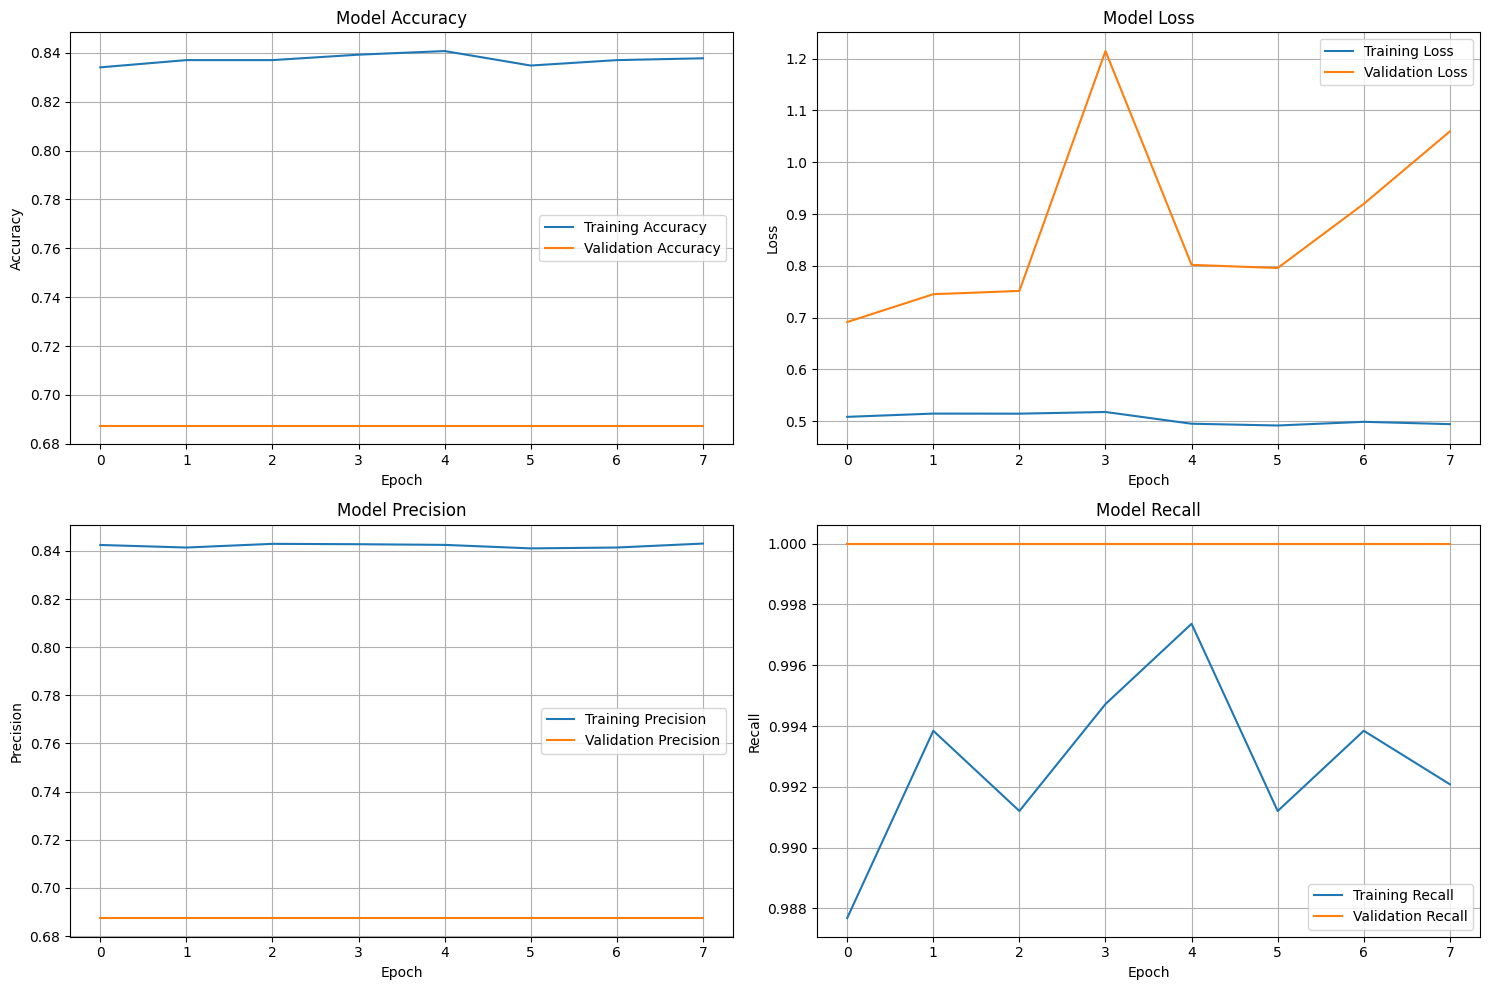

In [15]:
# Two-phase training
from tensorflow.keras.optimizers import Adam
# Phase 1: Train top layers
history = model.fit(
    train_gen,
    epochs=3,
    validation_data=val_test_gen,
    validation_steps=val_steps,
    callbacks=[early_stopping, reduce_lr]
)

# Phase 2: Fine-tune
model.layers[0].trainable = True
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)
history_fine = model.fit(
    train_gen,
    epochs=5,
    validation_data=val_test_gen,
    validation_steps=val_steps,
    callbacks=[early_stopping, reduce_lr]
)

# Plot combined history
combined_history = {key: history.history[key] + history_fine.history[key] for key in history.history}
plot_training_history(combined_history)

In [19]:
# Threshold optimization on validation set
def find_optimal_threshold(model, val_generator, steps):
    val_generator.reset()
    predictions = model.predict(val_generator, steps=steps, verbose=1)
    y_true = val_generator.classes[:steps * val_generator.batch_size]
    
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (predictions > threshold).astype(int).flatten()
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    print(f"Best threshold: {best_threshold:.3f}, Best F1 score: {best_f1:.4f}")
    return best_threshold

optimal_threshold = find_optimal_threshold(model, val_test_gen, val_steps)

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Best threshold: 0.100, Best F1 score: 0.8148


In [20]:
# Final evaluation on test set
val_test_gen.reset()
predictions_all = model.predict(val_test_gen, steps=None, verbose=1)  # Predict on all samples
val_samples = val_steps * val_test_gen.batch_size  # e.g., 9 * 32 = 288
predictions_test = predictions_all[val_samples:]   # Take test portion, e.g., 576 - 288 = 288 samples
y_true_test = val_test_gen.classes[val_samples:]   # Matches test portion, 288 samples
y_pred_optimal = (predictions_test > optimal_threshold).astype(int).flatten()  # Length 288

final_accuracy = accuracy_score(y_true_test, y_pred_optimal)
final_precision = precision_score(y_true_test, y_pred_optimal)
final_recall = recall_score(y_true_test, y_pred_optimal)
final_f1 = f1_score(y_true_test, y_pred_optimal)

print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final Precision: {final_precision:.4f}")
print(f"Final Recall: {final_recall:.4f}")
print(f"Final F1 Score: {final_f1:.4f}")

# Save the model
model.save('final_optimized_model.h5')
print("Model saved as 'final_optimized_model.h5'")

18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


Final Accuracy: 1.0000
Final Precision: 1.0000
Final Recall: 1.0000
Final F1 Score: 1.0000
Model saved as 'final_optimized_model.h5'
